In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
from libpysal.weights import Queen

import libpysal
from libpysal import examples
import os
import region as rg
from pysal.viz.splot.libpysal import plot_spatial_weights
from libpysal.weights import Queen, Rook
from region.max_p_regions.heuristics import MaxPRegionsHeu
from region.p_regions.azp import AZPBasicTabu

sns.set(style="whitegrid")


C:\Users\user\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
abb_link = 'C:\\Users\\user\\Desktop\\datas\\listings.csv'
zc_link = 'C:\\Users\\user\\Desktop\\datas\\Zipcodes.geojson'

In [3]:
lst=pd.read_csv(abb_link)  # abb_link ile bir data frame olusturduk

In [4]:
varis=['bedrooms','bathrooms','beds']

In [5]:
aves = lst.groupby('zipcode')[varis].mean()
aves.info()
# zipcode lara göre bedrooms,bathrooms,beds verilerini ayırıyor bir zipcode ile eşleşen sayıların ortalamasını alıyor
# mesela 3000 zipcode lu evlerde ortalama 3 yatak var gibi sıralıyor

<class 'pandas.core.frame.DataFrame'>
Float64Index: 47 entries, 33558.0 to 78759.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   47 non-null     float64
 1   bathrooms  47 non-null     float64
 2   beds       47 non-null     float64
dtypes: float64(3)
memory usage: 1.5 KB


In [6]:
types = pd.get_dummies(lst['property_type']) # evlere göre property typeları ayırıyor.
# eger bir ev villa ise villaya 1 yazıyor apartmana 0 yazıyor gibi 
prop_types = types.join(lst['zipcode']).groupby('zipcode').sum()  
# .join icin => types diye tamamen farklı bir data seti yarattık. Bunu datamızda olan zipcodelarla birleştiriyoruz.
# .groupby icin=> üstte yaptığımız gibi zipcodelara göre grupluyoruz
# .sum icin=>  Bu sefer ortalamalarına değil toplamlaraına göre sıralıyoruz. Eger apartman ise apartman bloguna 1 yazmıştık. 
# Bunları toplayarak aslında bir zipcode da kaç apartman olduğunu görebiliyoruz.
prop_types_pct = (prop_types * 100.).div(prop_types.sum(axis=1), axis=0) # div fonksiyonu icinde: 
# toplam apartman sayısını hesaplıyor daha sonra rowlara bölüyor. Yani bir zipcode da kaç apartman olma olasılığını yazıyor.
# Hepsine bunu yapıyor (villa,bungalow vb.) 
prop_types_pct.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 47 entries, 33558.0 to 78759.0
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Apartment        47 non-null     float64
 1   Bed & Breakfast  47 non-null     float64
 2   Boat             47 non-null     float64
 3   Bungalow         47 non-null     float64
 4   Cabin            47 non-null     float64
 5   Camper/RV        47 non-null     float64
 6   Chalet           47 non-null     float64
 7   Condominium      47 non-null     float64
 8   Earth House      47 non-null     float64
 9   House            47 non-null     float64
 10  Hut              47 non-null     float64
 11  Loft             47 non-null     float64
 12  Other            47 non-null     float64
 13  Tent             47 non-null     float64
 14  Tipi             47 non-null     float64
 15  Townhouse        47 non-null     float64
 16  Treehouse        47 non-null     float64
 17  Villa

In [7]:
aves_props = aves.join(prop_types_pct)
db = pd.DataFrame(\
                 scale(aves_props),index=aves_props.index,columns=aves_props.columns).rename(lambda x: str(int(x)))  
#  scale() => dataları uygun distributionlara fitlemek için bir stanrdization yapılıyor burda. 
# Mesela normal distributiondan standard normal distribution a geçiş gibi. Veya binomial dan normal distributiona geçmek gibi.
#  index =>indexlerin ismine index veriliyor
#  columns => columnsların ismine columns veriliyor
# .rename => veriler sıralanırken kullanılan 1,2,3,4... sayıları str olarak veiliyor.

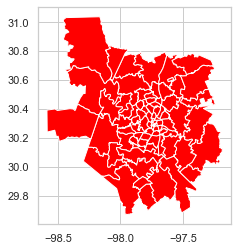

In [8]:
zc = gpd.read_file(zc_link)  
# zc_link dosyasında geometrik datalar oluşturabilecek datalar var o yüzden geopandas ile okutuyoruz
zc.plot(color='red');

In [9]:
zdb = zc[['geometry', 'zipcode', 'name']].join(db, on='zipcode').dropna()  # .dropna() => drops the null values
                                                                        #join => zc ile db yi birlestiriyor.
    
                                         

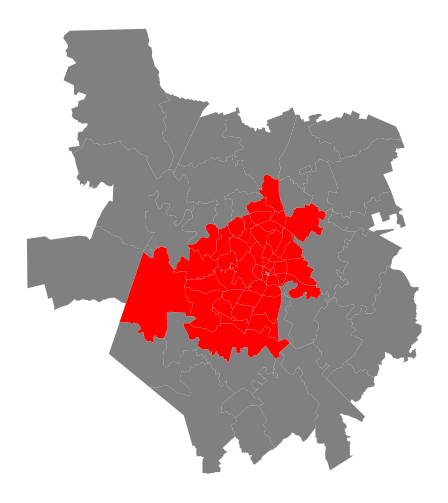

In [10]:
f, ax = plt.subplots(1, figsize=(9, 9))  # cıkacak görüntünün boyutunu figsize ile ayarlıyoruz

zc.plot(color='grey', linewidth=0, ax=ax) 
# sınırların aralarındaki çizgilerin genişlikleri(belirginlikleri) linewidth ile ayarlanıyor
zdb.plot(color='red', linewidth=0.1 , ax=ax)
# ax bizim olusturdugumuz bir plot alanı. ax=ax yaparak ikisinide aynı alanda gösteriyoruz. 
# eğer birine yazmazsak başka bir alanda gösterilir.


ax.set_axis_off()   # axisleri kapatıyor
plt.show()  # plotu yazdırmak için 
# Ustte dusurdugumuz nulll degerleri bizim kaybettigimiz alanlar oluyor. 
# Zc bütün zipcodelara sahip ama zbd sadece bizim girdiğimiz verilerle sınırlı o yüzden kayıp yaşanıyor. 
# gri zc kırmızı zbd olarak plotlanıyor.
    

In [11]:
km5 = cluster.KMeans(n_clusters=8) # 5 küme oluşturmasını söylüyoruz.


In [12]:
km5cls = km5.fit(zdb.drop(['geometry', 'name'], axis=1).values) 
# geometry ve name columnlarını dropluyor ve sadece values larını alıp KMeans ile fitliyor.
#Rastgele 5 nokta belirliyor.
#Dataların noktalara uzaklıkları alınıyor
#Data hangi noktaya daha yakınsa o noktanın kümseine dahil oluyor
#Kümelendikten sonra kümelerdeki dataların ortalamaları alınıyor.
#Ortalamaya göre merkez noktası kayıyor ve aynı işlem baştan tekrar  gerçekleşiyor


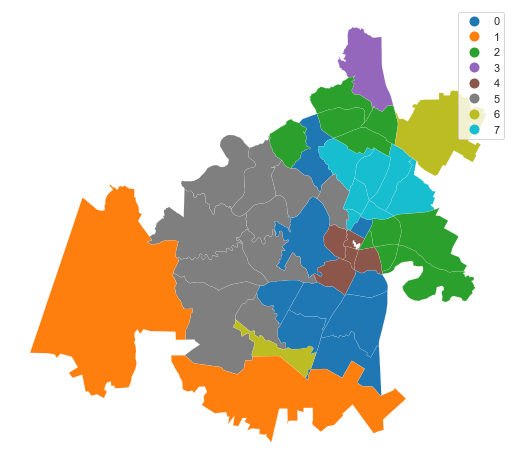

In [13]:
f, ax = plt.subplots(1, figsize=(9, 9))

zdb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True,legend=True,\
         linewidth=0.1, edgecolor='white', ax=ax)
#.assign () => dataların kmeans ile oluşturulmuş labellaarını yeni bir column (cl olarak adlandırıyor) oluşturarak dataya yazıyor.
# cl column unu gösterecek şekilde plotlanıyor. 
#categorical 0-1-2-3-4 olarak categorize edilmesine yarıyor, legend ise sağ üstte bulunan göstergeyi açıyor.
# kmeans in atamış olduğu labels lar rastgele atanıyor. önemli olan belirttiği alanlar.
ax.set_axis_off() # axisleri kapatıyor

plt.show()


In [14]:
cl_pcts = prop_types_pct.rename(lambda x: str(int(x)))\
                          .reindex(zdb['zipcode'])\
                          .assign(cl=km5cls.labels_)\
                          .groupby('cl')\
                          .mean()
# burda kmeans ile dataları ayırmış olduğumuz labellara göre datayı sınıflandırıyor. Ortalamalarını alarak sıralıyor.

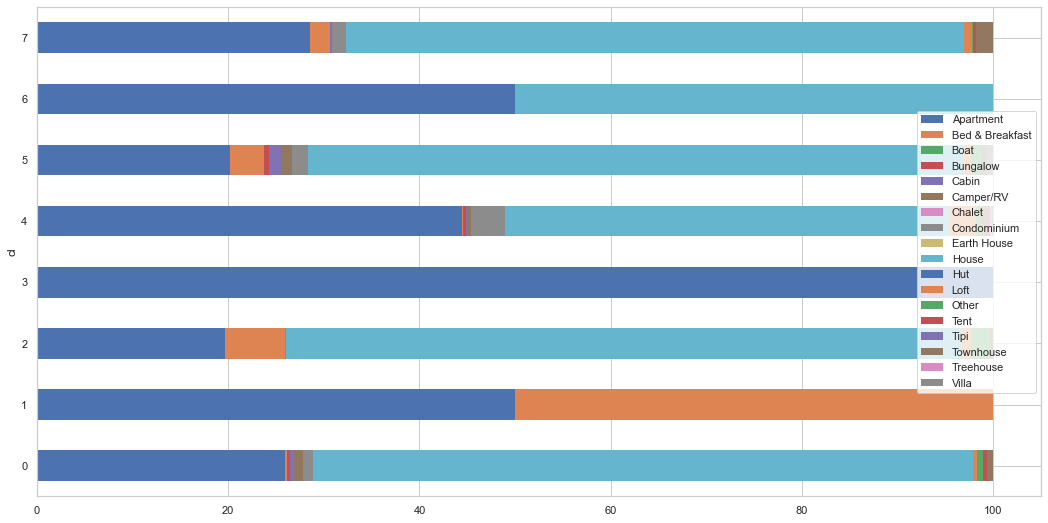

In [15]:
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax, \
            linewidth=0)
ax.legend(ncol=1, loc="right");
# cmap Set2 yaptığımızda renkler çok yakın oluyor düzgün gözükmüyor o yüzden o kodu sildim.


In [16]:
ratings = [i for i in lst if 'review_scores_' in i]
ratings
# lst datasındaki rewiew_scores_ ile başlayan variable listelerini içine yazıyor

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [17]:
rt_av = lst.groupby('zipcode')[ratings]\
           .mean()\
           .rename(lambda x: str(int(x)))
# Burda üstlerde yaptığımız gibi ratingsleri zipcode'a göre sıralıyor. 
# Sıralarken ratingslerin ortalamalarını alarak sıralıyor.

In [18]:
zrt = zc[['geometry', 'zipcode']].join(rt_av, on='zipcode')\
                                 .dropna()
zrt.info()
# üstte oluşturduğumuz datayı zipcodeların geometrisiyle birleştiriyoruz. Bu sayede geometrik bir plot alacağız.

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 43 entries, 0 to 78
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   geometry                     43 non-null     geometry
 1   zipcode                      43 non-null     object  
 2   review_scores_rating         43 non-null     float64 
 3   review_scores_accuracy       43 non-null     float64 
 4   review_scores_cleanliness    43 non-null     float64 
 5   review_scores_checkin        43 non-null     float64 
 6   review_scores_communication  43 non-null     float64 
 7   review_scores_location       43 non-null     float64 
 8   review_scores_value          43 non-null     float64 
dtypes: float64(7), geometry(1), object(1)
memory usage: 3.4+ KB


C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23f76db7e20>)

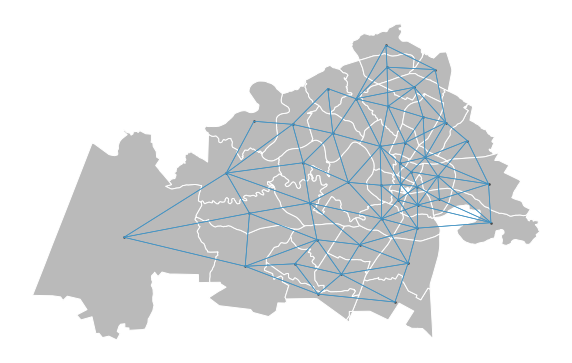

In [19]:

zrt.to_file('tmp')   # zrt datasını tmp dosyasına ye atıyoruz
#w =Queen.from_shapefile('C:\\Users\\user\\Desktop\\Arastirma Gorevi\\tmp\\tmp.shp', idVariable='zipcode')
# Queen spatial weight teknigiyle iki alanın komsu olup olmadıgını belirleyebiliyoruz. Burda onu yapıyoruz.

gdf=gpd.read_file('C:\\Users\\user\\Desktop\\Arastirma Gorevi\\tmp\\tmp.shp')

w_queen=Queen.from_dataframe(gdf)
plot_spatial_weights(w_queen,gdf,figsize=(10,10))



#  code        w_queen=Queen.from_shapefile('C:\\Users\\user\\Desktop\\Arastirma Gorevi\\tmp\\tmp.shp', idVariable='zipcode')
#  code       tmp=gpd.read_file('C:\\Users\\user\\Desktop\\Arastirma Gorevi\\tmp\\tmp.shp')
#  code       w_rook=Rook.from_shapefile('C:\\Users\\user\\Desktop\\Arastirma Gorevi\\tmp\\tmp.shp', idVariable='zipcode')



#os.remove('C:\\Users\\user\\Desktop\\Arastirma Gorevi\\tmp\\tmp.shp') # tmp dosyasını siliyoruz


# Burda zipcode ların sahip oldukları weightleri görüyoruz. Her 1 sayısı bir komsusu oldugunu belirtir.
#queen_card = pd.Series(w.cardinalities)
#queen_card.head()
#sns.distplot(queen_card, bins=10)
# daha iyi anlamak için görselleştirdim

#   code      plot_spatial_weights(w_rook,tmp,figsize=(5,5))

C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\user\anaconda3\lib\site-packages\pysal\viz\splot\_viz_libpysal_mpl.py:126: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23f76cbc700>)

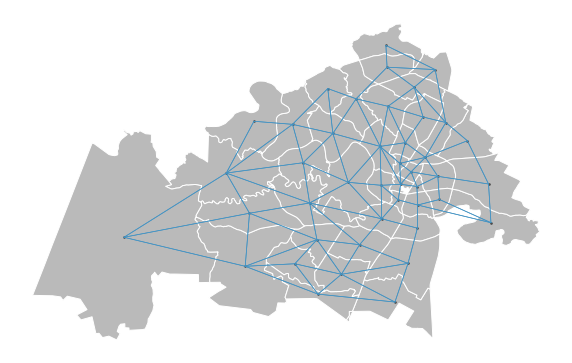

In [20]:
w_rook=Rook.from_dataframe(gdf)
plot_spatial_weights(w_rook,gdf,figsize=(10,10))

In [21]:
n_rev = lst.groupby('zipcode')\
           .sum()\
           ['number_of_reviews']\
           .rename(lambda x: str(int(x)))\
           .reindex(zrt['zipcode'])
thr = np.round(0.1 * n_rev.sum())
thr
# Burda görüntüleyeceğimiz bölgelerin en az toplam görüntülenmenin %10 una sahip olması için 
# toplam görüntülenmenin %10'unu hesaplıyoruz
# n_rev
# n_rev[:,None]

6271.0

In [22]:
np.random.seed(1234)  # tek ve belirli bir random number yaratmak için kullanılıyor

z = zrt.drop(['geometry', 'zipcode'], axis=1).values 
# önceden yaptıgımız gibi datanın sadece variablelarını alıyor ki maxp yi beslesin
#maxp = ps.region.Maxp(w, z, thr, n_rev.values[:, None], initial=1000)  # %10 altındaki değerleri elimine ediyor
# maxp =>  review sayılarının toplamına göre bir gruplama yapıyor.
#maxp.area2region

model_q = MaxPRegionsHeu()
model_q.fit_from_w(w_queen,z,n_rev.values[:, None], thr)
model_r =MaxPRegionsHeu()
model_r.fit_from_w(w_rook,z,n_rev.values[:,None],thr)



In [23]:
#%%time
#np.random.seed(1234)
#maxp.cinference(nperm=999)

In [24]:
#maxp.cpvalue

In [25]:
#lbls = pd.Series(maxp.area2region).reindex(zrt['zipcode'])  
# dataları işaretlemek için maxp ile elde ettiğimiz işaretlemeleri zipcode ile birleştiriyoruz.

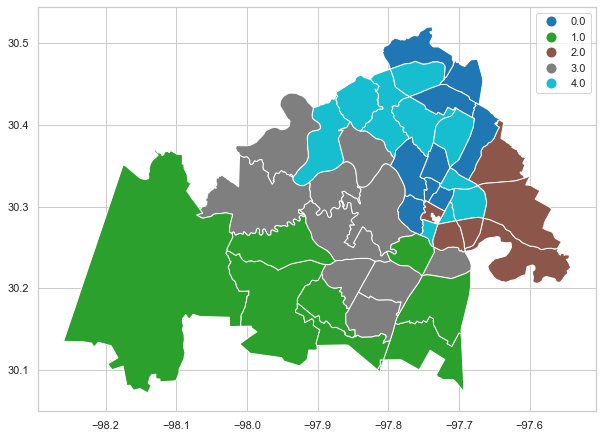

In [26]:
#f, ax = plt.subplots(1, figsize=(9, 9))

#zrt.assign(cl=lbls.values)\
#   .plot(column='cl', categorical=True, legend=True, \
#         linewidth=0.1, edgecolor='white', ax=ax)

#ax.set_axis_off()

#plt.show()
gdf.plot(column = model_q.labels_, categorical = True, figsize = (10, 10), legend = True)

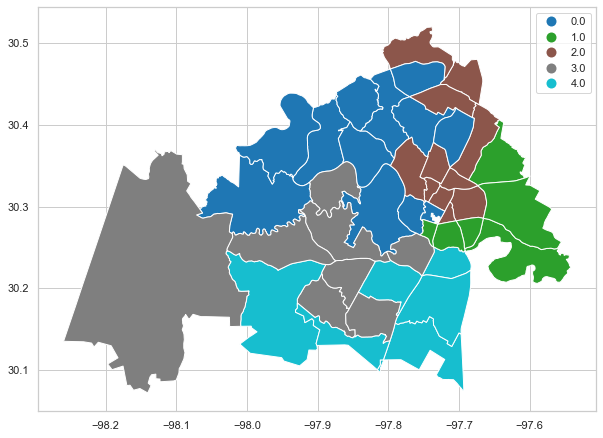

In [27]:
gdf.plot(column = model_r.labels_, categorical = True, figsize = (10, 10), legend = True)

In [28]:
zrt[ratings].groupby(model_q.labels_).mean().T

,0.0,1.0,2.0,3.0,4.0
review_scores_rating,96.259338,95.726852,92.604471,95.444372,94.467786
review_scores_accuracy,9.578482,9.795029,9.393447,9.709065,9.569919
review_scores_cleanliness,9.671237,9.292844,9.238010,9.445513,9.528958
review_scores_checkin,9.909281,9.935688,9.682768,9.870405,9.734029
review_scores_communication,9.893447,9.963684,9.705702,9.882806,9.772621
review_scores_location,9.581779,9.437219,8.856350,9.498229,9.442337
review_scores_value,9.619184,9.822716,9.277167,9.522877,9.472186
